# Mise en place du KNN sur le jeu de données farms_train.csv

## Import des bibliothèques
- pandas pour l'import des données
- pyplot, seaborn pour les visualisations
- sklearn pour l'algorithme KNN


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

## Import et prétraitement des données

In [ ]:
# Chargement des données avec le séparateur ";" et la virgule comme séparateur de décimales
data = pd.read_csv('../data/farms_train.csv', sep=';', decimal=',')

# On sépare la variable cible et les variables explicatives
X = data.drop(columns=['DIFF'])
y = data['DIFF']

# On divise les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# On normalise les variables explicatives
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Optimisation du nombre k par itération

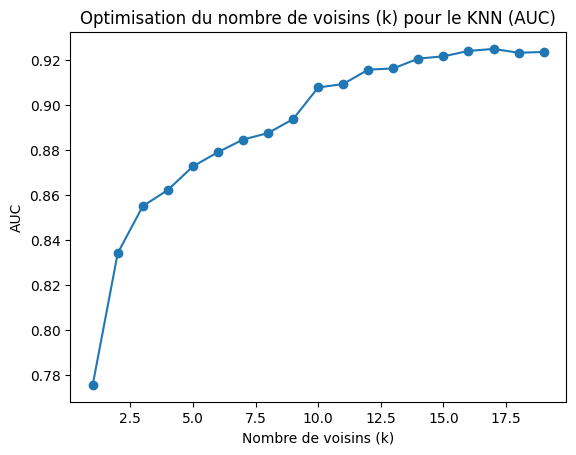

Meilleur nombre de voisins (k) basé sur l'AUC : 17 avec une AUC de 0.92


In [27]:
# Liste des valeurs de k à tester
k_values = range(1, 20)
auc_scores = []

# Validation croisée pour chaque valeur de k en calculant l'AUC
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Utiliser cross_val_score pour obtenir l'AUC moyenne avec 5 folds
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')
    auc_scores.append(scores.mean())

# Tracer l'AUC moyenne en fonction de k
plt.plot(k_values, auc_scores, marker='o')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("AUC")
plt.title("Optimisation du nombre de voisins (k) pour le KNN (AUC)")
plt.show()

# Trouver le k avec la meilleure AUC
best_k_auc = k_values[auc_scores.index(max(auc_scores))]
print(f"Meilleur nombre de voisins (k) basé sur l'AUC : {best_k_auc} avec une AUC de {max(auc_scores):.2f}")


On teste avec des itérations jusqu'à 150 pour voir si il est nécessaire d'augmenter l'intervalle k_values

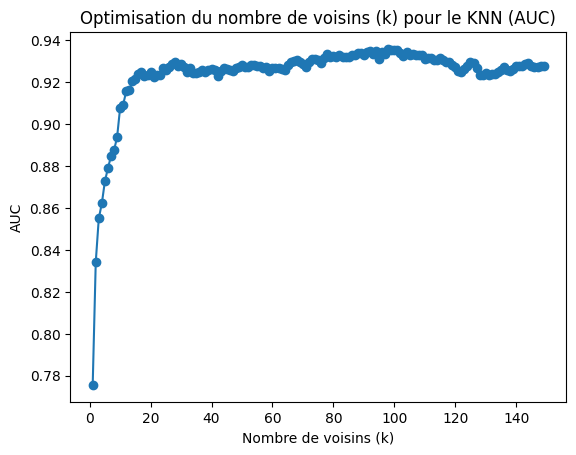

Meilleur nombre de voisins (k) basé sur l'AUC : 98 avec une AUC de 0.94


In [ ]:
# Liste des valeurs de k à tester
k_values_100 = range(1, 150)
auc_scores = []

# Validation croisée pour chaque valeur de k en calculant l'AUC
for k in k_values_100:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Utiliser cross_val_score pour obtenir l'AUC moyenne avec 5 folds
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')
    auc_scores.append(scores.mean())

# On trace l'AUC moyenne en fonction de k
plt.plot(k_values_100, auc_scores, marker='o')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("AUC")
plt.title("Optimisation du nombre de voisins (k) pour le KNN (AUC)")
plt.show()

# On identifie le k avec la meilleure AUC
best_k_auc = k_values_100[auc_scores.index(max(auc_scores))]
print(f"Meilleur nombre de voisins (k) basé sur l'AUC : {best_k_auc} avec une AUC de {max(auc_scores):.2f}")

On voit que ce n'est pas nécessaire car on ne gagne pas beaucoup d'AUC (+0.02) avec beaucoup plus d'itérations, ce qui augmente la complexité de l'algorithme

## Entraînement du modèle avec le meilleur k trouvé

In [33]:
# Réentraîner le modèle avec le meilleur k trouvé
knn_optimized = KNeighborsClassifier(n_neighbors=best_k_auc)
knn_optimized.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_optimized = knn_optimized.predict(X_test)


## Réalisation des prédictions

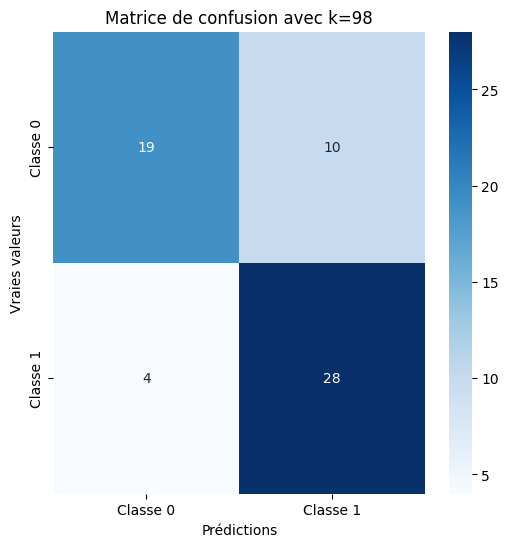

In [ ]:
# On fait des prédictions sur l'ensemble de test
y_pred = knn_optimized.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion en heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title(f'Matrice de confusion avec k={best_k_auc}')
plt.show()
plt.savefig('../images/confusion_matrix_knn.png')


## On visualise l'AUC (ROC)

AUC avec k=98: 0.85


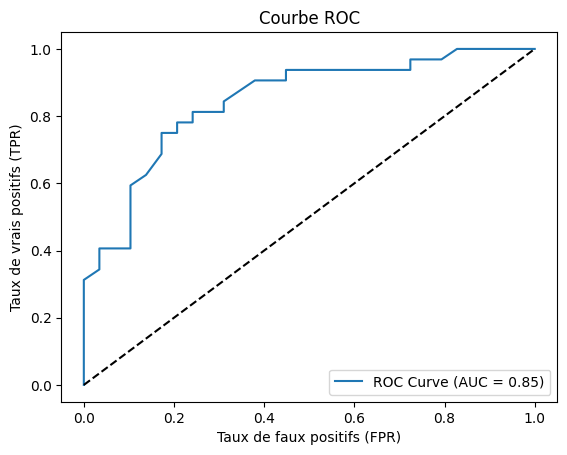

<Figure size 640x480 with 0 Axes>

In [37]:
# On calcule les probabilités de classe pour l'ensemble de test
y_proba = knn_optimized.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive

# Calcul de l'AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC avec k={best_k_auc}: {auc_score:.2f}")

# Traçage de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Ligne de référence pour une classification aléatoire
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.show()
# Sauvegarde de la courbe ROC en tant qu'image
plt.savefig('../images/roc_curve_knn.png')

In [ ]:
# Créer un DataFrame avec les prédictions
predictions_df = pd.DataFrame({
    'Id': range(len(y_pred)),  # Si vous voulez inclure un identifiant pour chaque prédiction (optionnel)
    'Prediction': y_pred
})

# Exporter les prédictions au format CSV
predictions_df.to_csv('predictions_knn.csv', index=False)

# Vérification du fichier exporté
print("Les prédictions ont été exportées dans 'predictions_knn.csv'")
